## Baseline classification

In this notebook basic implementation of query classification is provided. It based on:
    
https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

and provides implementation of Doc2Vec + Logistic Regression pipeline.

Since I didn't want this implementation to infere with BERT main pipeline, all of the code is provided directly in notebook.

In [1]:
import sys
sys.path.append("../src")

In [2]:
# # Installing gensim and seaborn due to problems with poetry

# !pip install gensim seaborn

In [3]:
from functools import partial
import multiprocessing
import random

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import wordpunct_tokenize, word_tokenize
import pandas as pd
import numpy as np
from sklearn import utils
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
import seaborn as sns
import string
import tensorflow as tf
from tqdm import tqdm

from adthena_task.config import Config

from baseline_utils import clean_text, tokenize_text, create_embedding_matrix, vec_for_learning

%matplotlib inline

In [4]:
config = Config()

Downloading stopwords and Punkt Tokenizer Model from nltk package.

In [5]:
# nltk.download('stopwords')
# nltk.download('punkt')

In [6]:
np.random.seed(config.SEED)
random.seed(config.SEED)

Basic data loading and preparing for further analysis.

In [7]:
data = pd.read_csv(config.DATA_DIR_TRAIN, header=None)
data.columns = ["Query", "Label"]
data = utils.shuffle(data, random_state=config.SEED)

# Creating stopwords from nltk and stemmer

stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer(language="english")

Creating partial from function to clean text queries.

In [8]:
clean_text_partial = partial(clean_text, stemmer=stemmer, stop_words=stop_words)
data["Clean_query"] = data["Query"].apply(clean_text_partial)

In [9]:
train, val = train_test_split(data, test_size=config.TEST_SIZE, random_state=config.SEED)
val, test = train_test_split(val, test_size=config.TEST_SIZE, random_state=config.SEED)

train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r["Clean_query"]), tags=[r["Label"]]), axis=1)
val_tagged = val.apply(
    lambda r: TaggedDocument(words=tokenize_text(r["Clean_query"]), tags=[r["Label"]]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r["Clean_query"]), tags=[r["Label"]]), axis=1)

In [10]:
# !wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
# !unzip glove.6B.zip

In [11]:
glove = pd.read_csv('glove.6B.100d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

In [12]:
text=["The cat sat on mat","we can play with model"]

tokenizer=tf.keras.preprocessing.text.Tokenizer(split=" ")
tokenizer.fit_on_texts(text)

text_token=tokenizer.texts_to_sequences(text)

embedding_matrix=create_embedding_matrix(tokenizer.word_index,embedding_dict=glove_embedding,dimension=100)

In [13]:
cores = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 3945/3945 [00:00<00:00, 534759.53it/s]


In [14]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)], random_state=config.SEED), 
                     total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 3945/3945 [00:00<00:00, 2320691.34it/s]


In [15]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_val, X_val = vec_for_learning(model_dbow, val_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [16]:
logreg = LogisticRegression(n_jobs=cores, C=1e5, verbose=True)
logreg.fit(X_train, y_train)
y_pred_val = logreg.predict(X_val)
y_pred = logreg.predict(X_test)
print('Validation accuracy %s' % accuracy_score(y_val, y_pred_val))
print('Validation F1 score: {}'.format(f1_score(y_val, y_pred_val, average='weighted')))
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Validation accuracy 0.6850912778904665
Validation F1 score: 0.6846793935480552
Testing accuracy 0.6710593005575266
Testing F1 score: 0.6713459123783398


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    3.1s finished


In [17]:
## Confusion matrix

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 33.0, 'Predicted label')

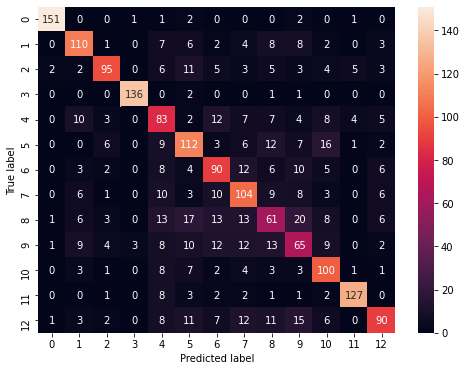

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
df_cm = pd.DataFrame(conf_matrix, index=logreg.classes_, columns=logreg.classes_)
sns.heatmap(df_cm,annot=True, fmt="d", ax=ax)
plt.ylabel("True label")
plt.xlabel("Predicted label")